# Multi-Layer Perceptron (Neural Network)
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv), and a Multilayer Perceptron.

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import util
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn import metrics


## Cleaning the Data

In [2]:
data = pd.read_csv("data.csv")
data = util.data_cleaner(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Data

<Figure size 1440x360 with 0 Axes>

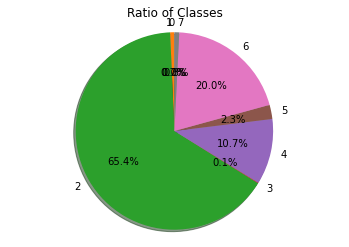

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


In [4]:
data_encoded, encoders = util.data_encoder(data)
util.pie_chart_y(data_encoded["Outcome"])
data_encoded.head()

As can be seen 65.4% of the time, the outcome of a stop and sarch is 65.4% 

In [13]:
outcome_classes = encoders["Outcome Encoder"].classes_

#Splt into X and y, while one-hot-encoding the target
X,y = util.to_xy(df=data_encoded, target="Outcome")

## Splitting to Train and Test

In [6]:
# Split into features and target
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

(132520, 9)


## The MLP

We start with a basic MLP:
- Input
- Hidden (64 unit, relu activation)
- Output (8 unit, softmax)

In [7]:
model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [8]:
%%time
model.fit(X_train,y_train,verbose=0,epochs=128)

In [9]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(f"Prediction\n{pred[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score}")

Prediction
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.6509613353053032


In [10]:
pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.2559282183647156


In [11]:
# Save the model
model.save("./models/score(65)-input-hidden(64-relu)-Output(8-softmax).h5")

The model was able to predict test set 65% of the time. It is highly biased to predict class 2 ("Nothing found - no further action"), suggesting an underfit of the data.

## Adding More Hidden Layers

We try to add more layers to alleviate the underfitting of our model

In [14]:
model2 = Sequential()
model2.add(Dense(64, input_dim=9, activation='relu')) # Hidden 1
model2.add(Dense(64, activation='relu')) # Hidden 2
model2.add(Dense(8, activation='softmax')) # Ouput
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
%%time
model2.fit(X_train,y_train,verbose=0, epochs=128)

In [16]:
pred2 = model2.predict(X_test)
pred2 = np.argmax(pred2,axis=1)
print(f"Prediction\n{pred2[:100]}")
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred2)
print(f"\nScore is {score}")

Prediction
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.6509311520932057


In [17]:
#Save the model
model.save("./models/score(65)-input-hidden(64-relu)-hidden(64-relu)-Output(8-softmax).h5")

Result not signficantly improved... still at around 66%.

# Sigmoid Activation (1 Hidden)

In [26]:
model_s = Sequential()
model_s.add(Dense(500, input_dim=9, activation='sigmoid'))
model_s.add(Dense(500, input_dim=9, activation='sigmoid'))
model_s.add(Dense(8, activation='softmax'))
model_s.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
%%time
model_s.fit(X_train,y_train,verbose=0,epochs=128)

CPU times: user 37min 11s, sys: 9min 37s, total: 46min 49s
Wall time: 9min 13s


In [29]:
pred = model_s.predict(X_test)
pred = np.argmax(pred,axis=1)
print(f"Prediction\n{pred[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score}")

Prediction
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.6509311520932057


In [22]:
model_s.save("./models/score(65)-input-hidden(64-sigmoid)-Output(8-softmax).h5")

## With K-Fold


In [ ]:
model_k = Sequential()
model_k.add(Dense(64, input_dim=9, activation='relu')) # Hidden 1
model_k.add(Dense(64, activation='relu')) # Hidden 2
model_k.add(Dense(64, activation='relu')) # Hidden 3
model_k.add(Dense(8, activation='softmax')) # Ouput
model_k.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
util.k_fold_train(model=model_k, folds=2, data=data_encoded, is_NN=True)

In [ ]:
pred_k = model_k.predict(X_test)
pred_k= np.argmax(pred_k,axis=1)
print(f"Prediction\n{pred_k[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred_k)
print(f"\nScore is {score}")

In [ ]:
#Save the model
model_k.save("./models/k_fold_3_hidden_2_folds_network.h5")

Score slightly higher, at 67%

# Using SMOTE
Technique for dealing with datasets where the frequency of one target class is signficantly higher than the rest.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [31]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [33]:
under_sample = RandomUnderSampler()
over_sample = SMOTE()

# Undersmaple
X_smote, y_smote = under_sample.fit_resample(X, y)

# Under then Over
X_smote_under, y_smote_under = under_sample.fit_resample(X, y)
X_smote, y_smote = over_sample.fit_resample(X_smote_under, y_smote_under)

print(X_smote.shape)

(328, 9)


In [12]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=10)
print(X_train.shape)
print(X_train_smote.shape)


(132520, 9)
(262, 9)


In [13]:
model_smote = Sequential()
units_per_layer = 64
model_smote.add(Dense(units_per_layer, input_dim=9, activation='relu'))
model_smote.add(Dense(units_per_layer, activation='relu')) # Hidden 1
model_smote.add(Dense(units_per_layer, activation='relu')) # Hidden 2
model_smote.add(Dense(8, activation='softmax'))
model_smote.compile(loss='categorical_crossentropy', optimizer='adam')

In [14]:
%%time
model_smote.fit(X_train_smote, y_train_smote ,verbose=0, epochs=128)

CPU times: user 1.66 s, sys: 1.03 s, total: 2.68 s
Wall time: 925 ms


In [15]:
pred_smote = model_smote.predict(X_test)
pred_smote = np.argmax(pred_smote,axis=1)
print(f"Prediction\n{pred_smote[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred_smote)
print(f"\nScore is {score}")

Prediction
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.10712021973378406


Score is significantly worse... perhaps because the SMOTE library equilizes all classes, instead of slightly over representing minority classes, in the case of multiclass classification. We try using SMOTE with binary classes next.

## SMOTE using Binary Classification

<Figure size 1440x360 with 0 Axes>

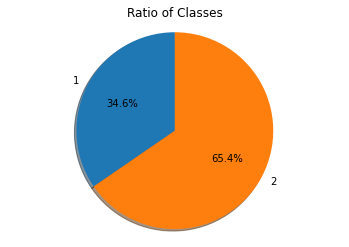

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,1,51.512286,-0.114491,1,1,1,1,8,1
1,1,1,51.512286,-0.114491,1,1,1,1,8,1
2,1,1,51.512286,-0.114491,1,1,1,1,8,1
4,1,2,51.512286,-0.114491,1,1,1,1,8,1
5,1,1,51.512286,-0.114491,1,1,1,1,1,2


In [21]:
#First we binarify the data
data_binary = util.binarify_from_encoded(data_encoded, nothing_value=2)
util.pie_chart_y(data_binary["Outcome"])
data_binary.head()

Split the data

In [20]:
# Xb,yb = util.to_xy(df=data_binary, target="Outcome")
target_b = data_binary["Outcome"]
features_b = data_binary.drop('Outcome', axis=1)

# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(target_b, features_b, test_size=0.2, random_state=10)

Use smote to decrease frequency of the class "2" ("Nothing found"), and increase all others

In [69]:
# _, frequencies = np.unique(data_binary["Outcome"], return_counts=True)
# print(frequencies)

[ 57298 108353]


109796


<Figure size 1440x360 with 0 Axes>

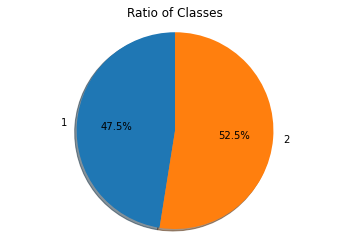

In [60]:
under_sample = RandomUnderSampler(sampling_strategy=0.9)
over_sample = SMOTE(sampling_strategy=0.6)

# Pipeline
steps = [('o', over_sample), ('u', under_sample)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_smote_b, y_smote_b = pipeline.fit_resample(features_b, target_b)

X_train_smote_b, X_test_smote_b, y_train_smote_b, y_test_smote_b = train_test_split(X_smote_b, y_smote_b, test_size=0.2, random_state=10)
print(len(X_train_smote_b))
util.pie_chart_y(y_train_smote_b)

In [80]:
model_smote_b = Sequential()
units_per_layer = 1000
model_smote_b.add(Dense(units_per_layer, input_dim=9, activation='sigmoid'))
model_smote_b.add(Dense(units_per_layer, activation='sigmoid')) # Hidden 1
# model_smote_b.add(Dense(units_per_layer, activation='sigmoid')) # Hidden 2
model_smote_b.add(Dense(1, activation='softmax'))
model_smote_b.compile(loss='categorical_crossentropy', optimizer='adam')

Xb_shape

In [81]:
%%time
model_smote_b.fit(X_train_smote_b, y_train_smote_b ,verbose=0, epochs=128)

CPU times: user 2h 57min 15s, sys: 27min 19s, total: 3h 24min 35s
Wall time: 35min 10s


In [82]:
y_test = np.array(y_test_smote_b)
pred_smote_b = model_smote_b.predict(X_test_smote_b)
print(len(y_test))
print(y_test)
print(len(pred_smote_b))
print(pred_smote_b)
score = metrics.accuracy_score(y_test, pred_smote_b)
print(f"\nScore is {score}")

27449
[1 1 2 ... 1 1 2]
27449
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]

Score is 0.4690516958723451
